<a href="https://colab.research.google.com/github/brendankirkpatrick/ImageClassification/blob/main/CIFAR100_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import packages
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization, ZeroPadding2D, MaxPool2D
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Add, AveragePooling2D
from tensorflow.keras import backend as k
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
from keras.datasets import cifar100
# load dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode="fine")

#convert to float datatype to divide by 255
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

169001437/169001437 [==============================] - 13s 0us/step


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)

In [ ]:
## Defining Hyperparameters
LR = 0.0001 # learning rate
batch_size = 40

In [ ]:
## retrieve ResNet50 from keras
def ResNet50_extractor(inputs):

  ResNet50_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(96, 96, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return ResNet50_extractor


## create final classification layers for CIFAR10
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(100, activation="softmax", name="classification")(x)
    return x


## Up sampling the input images of CIFAR10 to match 224x224 (what is used in pretrained ResNet)
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(3,3))(inputs)
    # after resizing, add input to resnet model with modified classification block at end
    resnet_feature_extractor = ResNet50_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

## compiling the model with Adam as opt and using categorical crossentropy loss
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= LR),
                loss= tf.keras.losses.categorical_crossentropy,
                metrics = ['accuracy'])

  return model

model = define_compile_model()

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 96, 96, 3)         0         
 g2D)                                                            
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              2098

In [ ]:
## Data augumentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    validation_split=0.2
)
datagen.fit(x_train)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.models import load_model

file_path = '/content/drive/My Drive/DL_Project/cifar100_resnet50_LR.0001_BS40_20.h5'

# load the saved model
saved_model = load_model(file_path)

# path chosen to save the model
save_path = '/content/drive/My Drive/DL_Project/cifar100_resnet50_LR.0001_BS40_20_cont.h5'

# initialize the ModelCheckpoint callback and early stopping
checkpoint = ModelCheckpoint(save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

## train the model
history = saved_model.fit(datagen.flow(x_train, y_train, batch_size= batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=300,
                    validation_data= datagen.flow(x_train, y_train,
                    batch_size=20, subset='validation'),
                    callbacks=[es, checkpoint]
                    )

Epoch 1/300
1250/1250 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9272
Epoch 1: val_loss improved from inf to 0.19688, saving model to /content/drive/My Drive/DL_Project/cifar100_resnet50_LR.0001_BS40_20_cont.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1250/1250 [==============================] - 193s 124ms/step - loss: 0.2246 - accuracy: 0.9272 - val_loss: 0.1969 - val_accuracy: 0.9380
Epoch 2/300
1250/1250 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9317
Epoch 2: val_loss improved from 0.19688 to 0.19258, saving model to /content/drive/My Drive/DL_Project/cifar100_resnet50_LR.0001_BS40_20_cont.h5
1250/1250 [==============================] - 157s 125ms/step - loss: 0.2139 - accuracy: 0.9317 - val_loss: 0.1926 - val_accuracy: 0.9393
Epoch 3/300
1250/1250 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9322
Epoch 3: val_loss did not improve from 0.19258
1250/1250 [==============================] - 159s 128ms/step - loss: 0.2077 - accuracy: 0.9322 - val_loss: 0.1931 - val_accuracy: 0.9397
Epoch 4/300
1250/1250 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9344
Epoch 4: val_loss did not improve from 0.19258
1250/1250 [==============================] - 149s 119

In [ ]:
## graphing
def get_plot(history):

    # plot the loss and performance of the training and validation from the model.fit
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    training_acc = history.history['accuracy']
    validation_acc = history.history['val_accuracy']

    # Create subplots for loss
    plt.figure(figsize=(12, 8))

    # Creating training and validation loss plot
    plt.subplot(2, 1, 1)
    plt.plot(training_loss, label='Training')
    plt.plot(validation_loss, label='Validation')
    plt.title('ResNet50 CIFAR100 Loss, LR=' + str(LR))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # creating training and validation accuracy plot
    plt.subplot(2, 1, 2)
    plt.plot(training_acc, label='Training')
    plt.plot(validation_acc, label='Validation')
    plt.title('ResNet50 CIFAR100 Accuracy, LR=' + str(LR))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

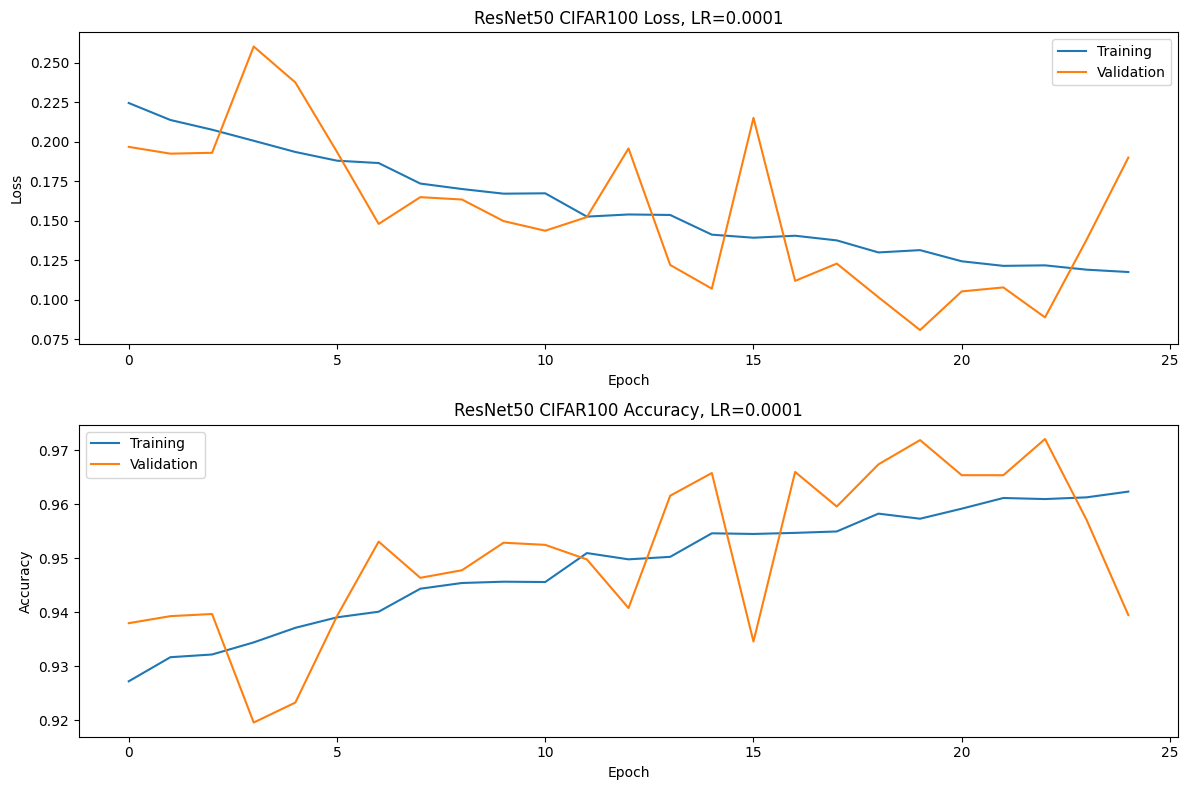

In [ ]:
get_plot(history)

In [ ]:
def test_model(file_path):
    #load the trained model and the test dataset to predict
    from keras.models import load_model

    # load the saved model
    saved_model = load_model(file_path)
    pred = saved_model.predict(x_test)
    pred_classes = np.argmax(pred, axis= 1)
    y_test_classes = np.argmax(y_test, axis= 1)

    #pred = pred.flatten()

    #Report accuracy
    accuracy = accuracy_score(y_test_classes, pred_classes)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # Generate and print a classification report
    print("Classification Report:")
    print(classification_report(y_test_classes, pred_classes))

    # Generate and print a confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_classes, pred_classes))

    # Calculate accuracy for each class
    class_accuracies = []
    for class_label in range(10):  # Assuming there are 10 classes in CIFAR-10
        class_indices = y_test_classes == class_label
        class_accuracy = accuracy_score(y_test_classes[class_indices], pred_classes[class_indices])
        class_accuracies.append(class_accuracy)

    # Class labels for CIFAR-10
    class_labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), class_accuracies, color='blue', alpha=0.7)
    plt.title('Classification Accuracies for Each Class (CIFAR-10)')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.xticks(range(10), class_labels, rotation=45, ha='right')
    plt.ylim(0, 1.0)  # Set y-axis limit to 1.0 for better visualization
    plt.show()



313/313 [==============================] - 9s 24ms/step
Overall Accuracy: 94.20%
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1000
           1       0.96      0.98      0.97      1000
           2       0.93      0.93      0.93      1000
           3       0.89      0.89      0.89      1000
           4       0.95      0.93      0.94      1000
           5       0.93      0.88      0.91      1000
           6       0.94      0.97      0.95      1000
           7       0.95      0.97      0.96      1000
           8       0.96      0.96      0.96      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Confusion Matrix:
[[944   4  16   1   1   1   2   0  19  12]
 [  1 979   0   0   0   0   0   0   2  18]
 [  5   0 934  16   6   9  20   5

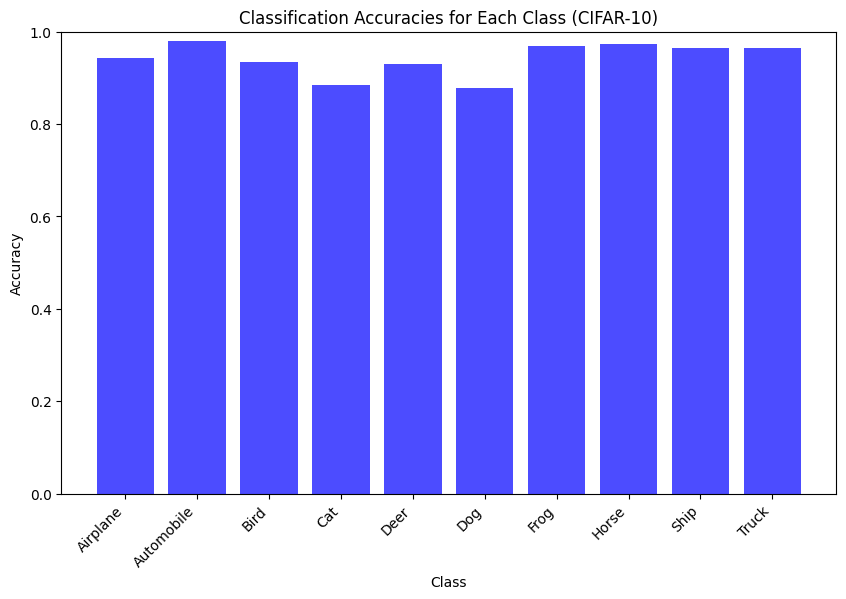

In [ ]:
test_model(save_path)